In [247]:
#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats as stats
import copy
import pandas as pd
from icecream import ic

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [248]:
# import data
data = pd.read_csv('era_interim_SH_eke_300hPa.csv', header= None)
# making data a numpy array
x = data[0].to_numpy()

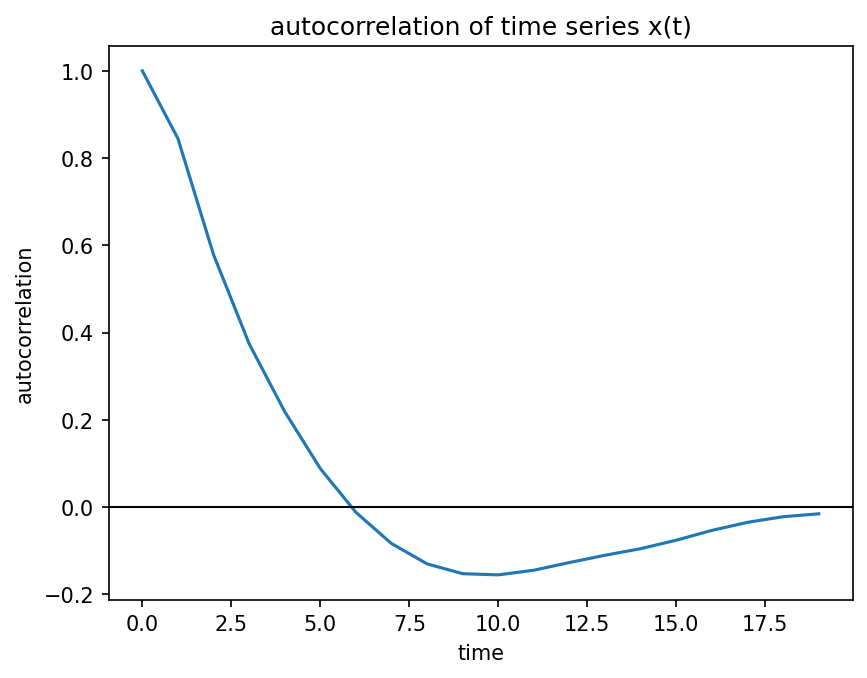

In [249]:
# correlate x1 with itself to calculate the autocorrelation
# note, can also use np.corrcoef()
c = np.correlate(x,x, 'same')/(np.var(x)*np.size(x)) 
c = c[int(np.size(c)/2):]    
# plot the autocorrelation
plt.figure()
plt.plot(c[0:20])
plt.title('autocorrelation of time series x(t)')
# add a horizontal line at 0
plt.axhline(0, color='black', lw=1)
plt.xlabel('time')
plt.ylabel('autocorrelation')
plt.show()


In [250]:
# input parameters
T = 256         #length of window
# N = 40          #number of realizations
N = np.size(x)/ T         #number of realizations
# alpha = 0.5     #red noise lag-one autocorrelation
alpha = c[1]     #red noise lag-one autocorrelation
# if alpha was defined using e-folding time, convert to lag-one autocorrelation
# alpha_e = 1./np.exp(1.)

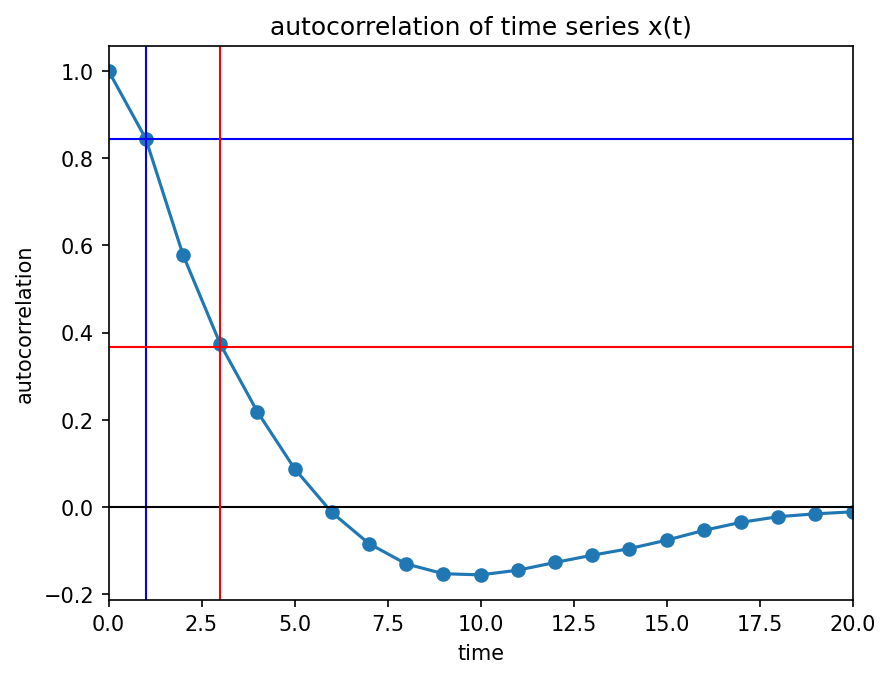

In [251]:
# find the time e-folding time scale
# t_e is the time at which the autocorrelation drops to 1/e
# t_e = np.where(c < 1/np.exp(1))[0][0]
# Calculate the absolute difference between each element in c and 1/e
diff = np.abs(c - 1/np.exp(1))

# Find the index of the smallest difference
t_e = np.argmin(diff)


alpha_e = np.exp(-1/t_e)
# calculate at what time the autocorrelation drops to 1/e
t = np.arange(0,np.size(c),1)
# plot the autocorrelation
plt.figure()
plt.plot(t,c)
plt.scatter(t,c)
plt.title('autocorrelation of time series x(t)')
# add a horizontal line at 0
plt.axvline(1, color='blue', lw=1)
plt.axhline(alpha, color= 'blue', lw=1)
plt.axhline(0, color='black', lw=1)
# plt.axhline(alpha, color='red', lw=1)
plt.axvline(t_e, color='red', lw=1)
plt.axhline(1/np.exp(1), color='red', lw=1)
# plt.axhline(alpha_e, color='red', lw=1)
plt.xlim(0,20)
plt.xlabel('time')
plt.ylabel('autocorrelation')
plt.show()


In [252]:
# define your timesteps and frequencies
T2 = T/2
freq = np.arange(0.,T2+1.)/T

In [253]:
# contstruct expected rednoise spectrum with alpha of lag-one autocorrelation
rspec = []
for i in np.arange(1,T2+2,1):
    rspec.append((1.-alpha*alpha)/(1.-2.*alpha*np.cos(np.pi*(i-1.)/T2)+alpha*alpha))
    
# contstruct expected rednoise spectrum with alpha of e-folding time
rspec_e = []
for i in np.arange(1,T2+2,1):
    rspec_e.append((1.-alpha_e*alpha_e)/(1.-2.*alpha_e*np.cos(np.pi*(i-1.)/T2)+alpha_e*alpha_e))

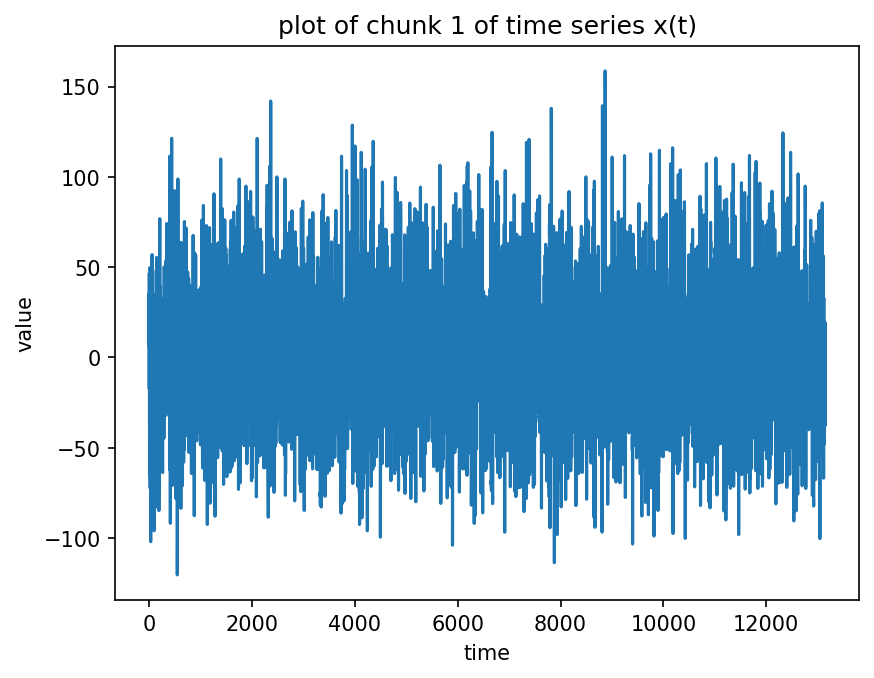

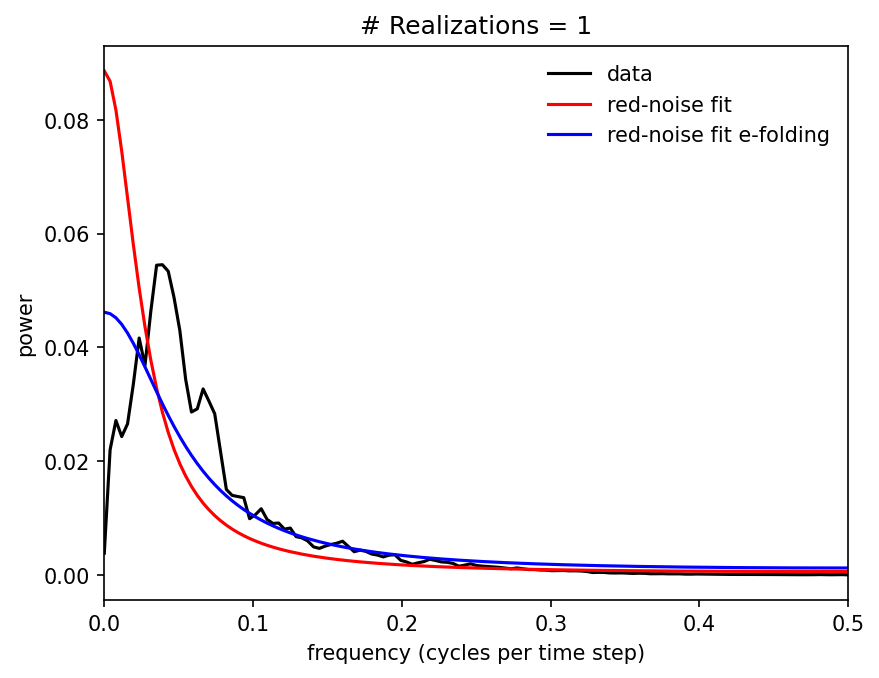

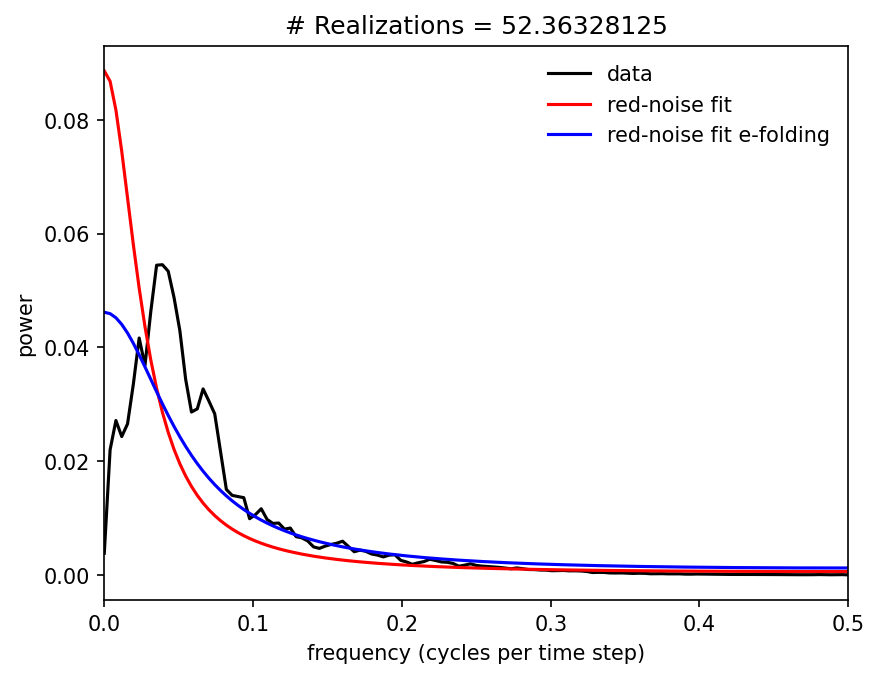

In [254]:
# factor = np.sqrt(1.-alpha*alpha)
# x = np.zeros(T,)

# loop realizations
# for ir in np.arange(0,N,1):
for ir in [0, N]:
    
    # # make a fake red noise time series
    # x = np.zeros(T,)
    # x[0] = x[-1]*alpha + factor*np.random.randn()

    # for j in np.arange(1,T,1):
    #     #add a cosine to our data to give it some additional power at a particular frequency of 50/256=0.2 cycles/time step
    #     x[j] = (x[j-1]*alpha 
    #             + factor*np.random.randn() 
    #             + 0.55*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*50./256.*j)
    #            )
    
    # # for illustrative purposes, add a mean for x (comment out)
    # x = x + 1.
    # 
    if(ir==0):
        plt.figure()
        plt.plot(x)
        plt.title('plot of chunk 1 of time series x(t)')
        plt.xlabel('time')
        plt.ylabel('value')
        plt.show()
    
    # calculate the power spectrum using a hanning window
    p = sig.welch(x,window='hann', nperseg=T, detrend='constant') #detrend='constant', None, 'linear'
    if(ir==0):
        psum = p[1]
    else:
        psum = psum + p[1]

    # calculate average    
    pave = psum/(ir+1.0)
    #normalize the spectrum
    pave = pave/np.mean(pave)
 
    
    # calculate significance
    dof = 2.*(ir+1.)
    fstat = stats.f.ppf(.99,dof,1000)
    spec99 = [fstat*m for m in rspec]
    
    # make pave, rspec, and spec99 integral over frequency to be 1 # Masoud
    pave = pave/np.sum(pave)
    rspec = rspec/np.sum(rspec)
    rspec_e = rspec_e/np.sum(rspec_e)
    # spec99 = spec99/np.sum(spec99)
    
    # if((ir+1.) % 5 == 0 or ir==0):   
    if(ir == N or ir==0):
        plt.figure()
        plt.xlabel('frequency (cycles per time step)')
        plt.ylabel('power')
        plt.title('# Realizations = ' + str(ir+1))
        # plt.ylim(0,20.)
        plt.xlim(0,0.5)
        plt.plot(freq,pave,'-k', label = 'data')
        plt.plot(freq,rspec,'-', label = 'red-noise fit', color = 'red')
        plt.plot(freq,rspec_e,'-', label = 'red-noise fit e-folding', color = 'blue')
        # plt.plot(freq,spec99,'--', label = '99% confidence', color = 'red')
        plt.legend(frameon = False)

plt.show()


In [255]:
ic(np.sum(pave))
ic(np.sum(rspec))
# np.sum(spec99)

ic| np.sum(pave): 1.0
ic| np.sum(rspec): 1.0


1.0

In [256]:
alpha = alpha_e

In [257]:
# contstruct expected rednoise spectrum
rspec = []
for i in np.arange(1,T2+2,1):
    rspec.append((1.-alpha*alpha)/(1.-2.*alpha*np.cos(np.pi*(i-1.)/T2)+alpha*alpha))

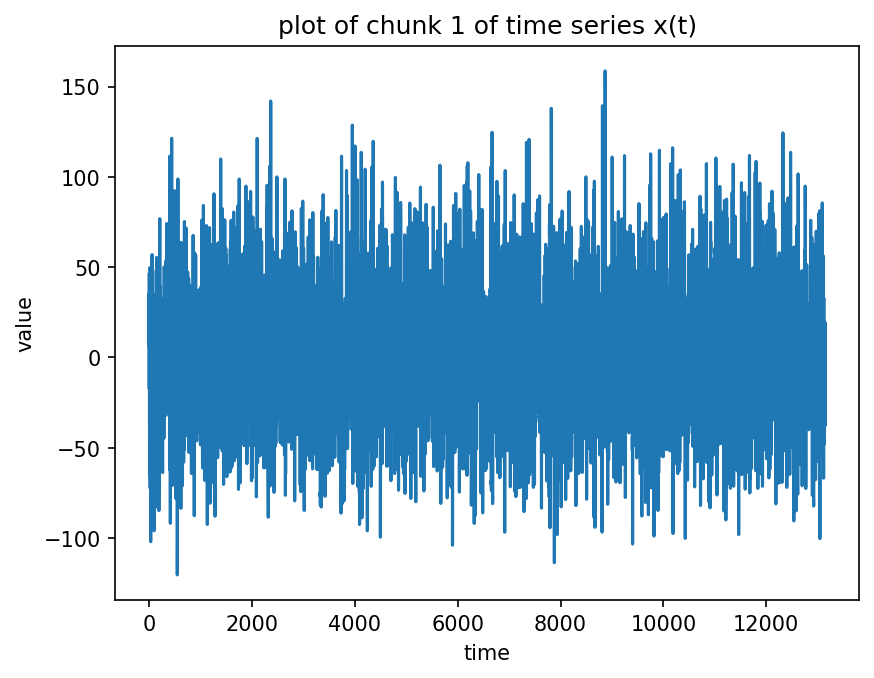

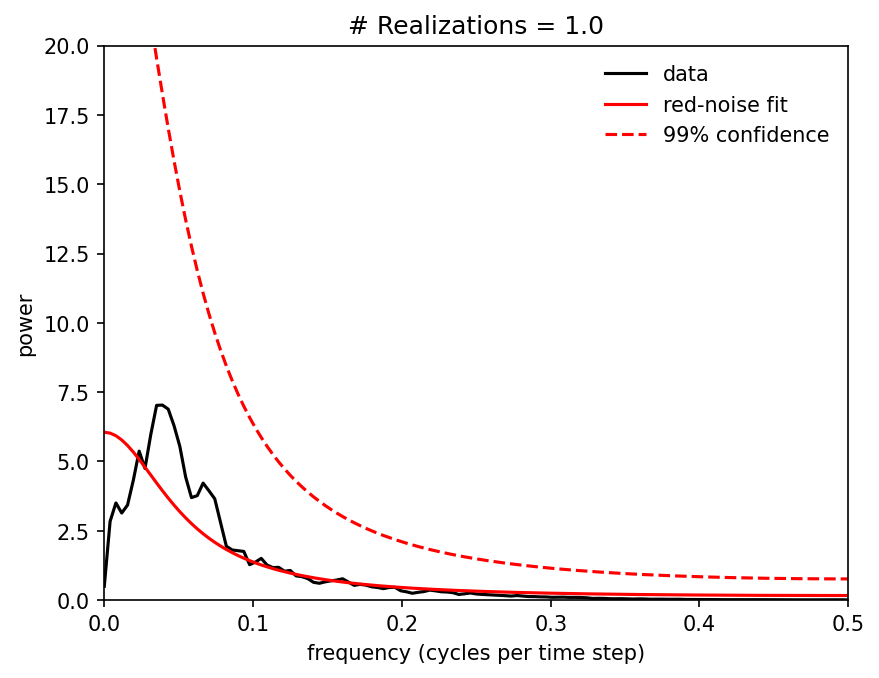

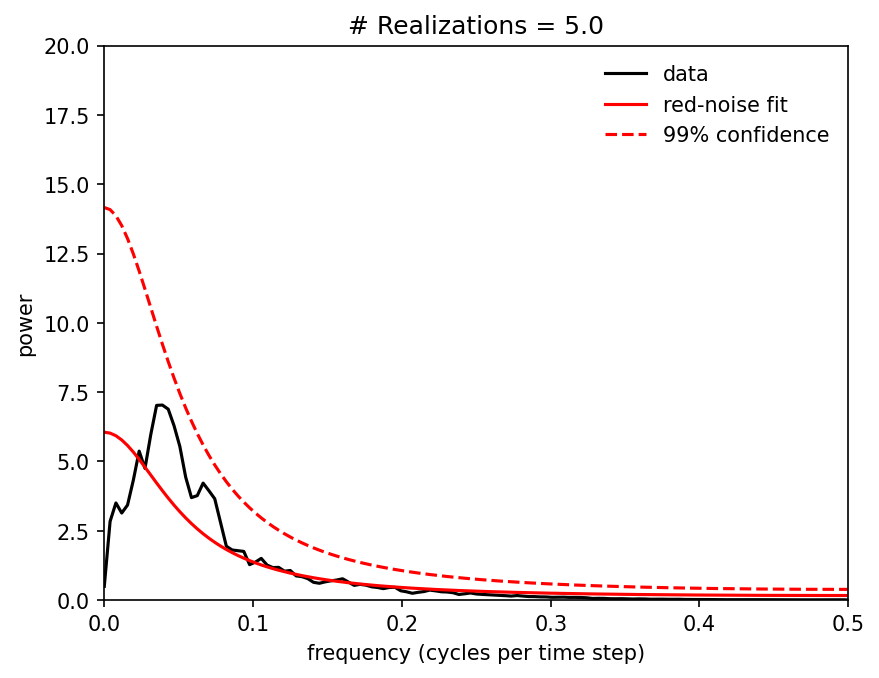

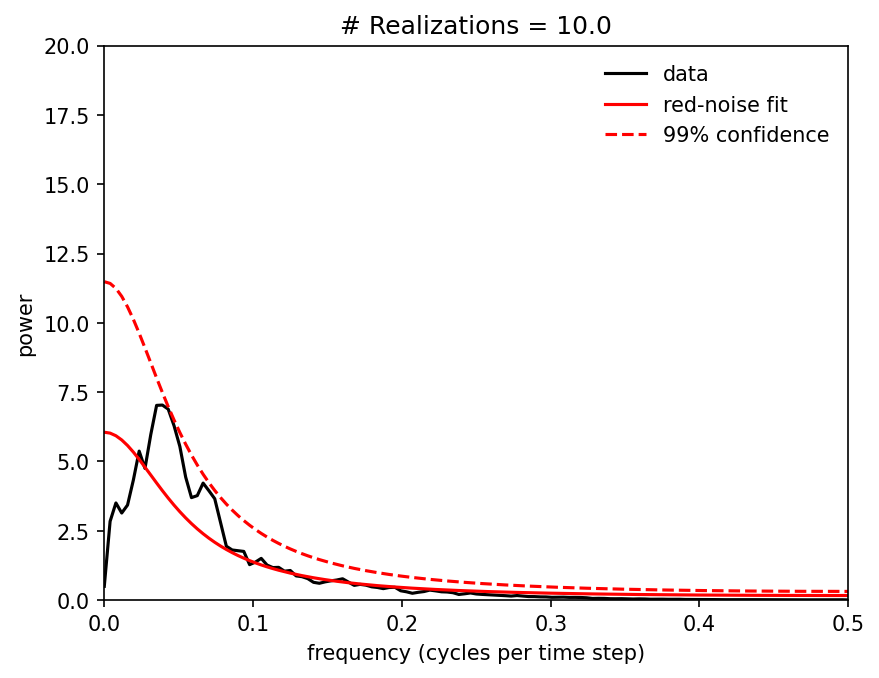

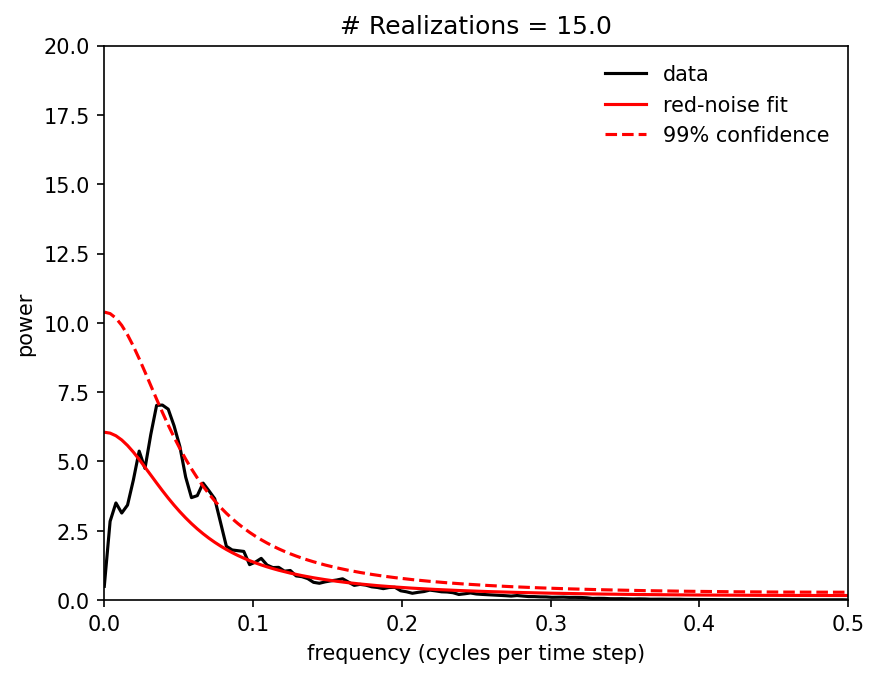

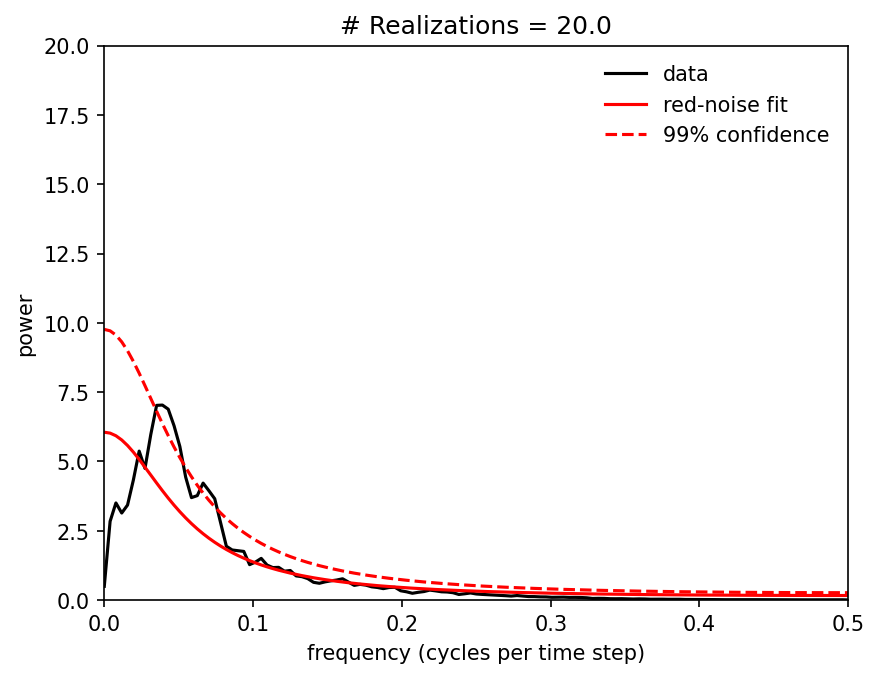

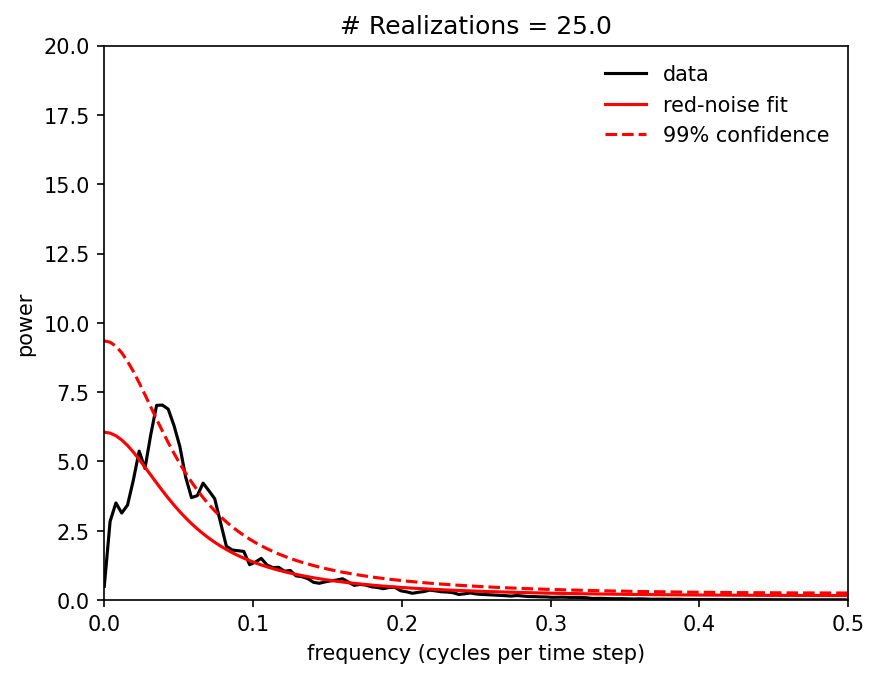

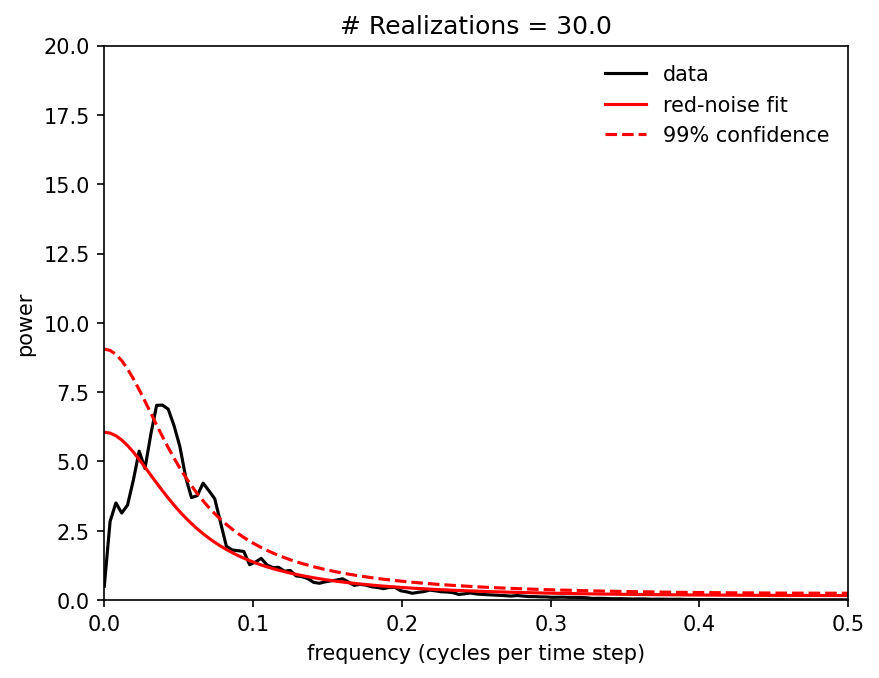

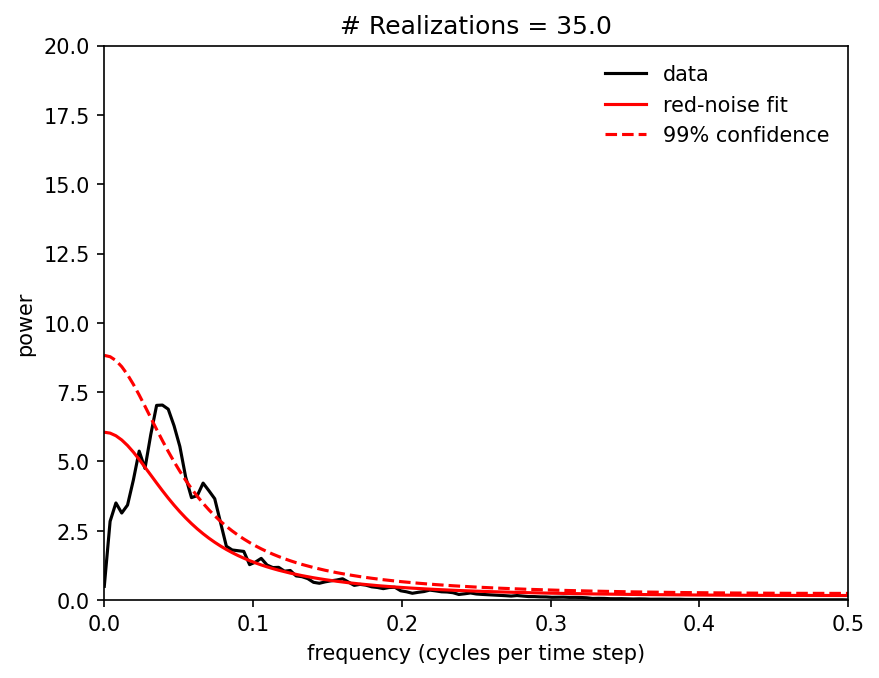

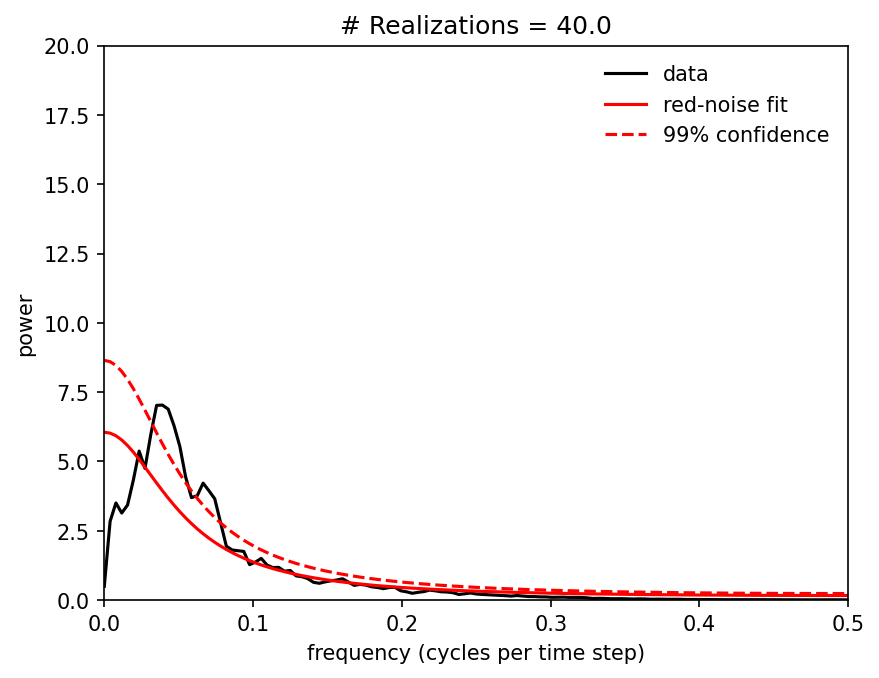

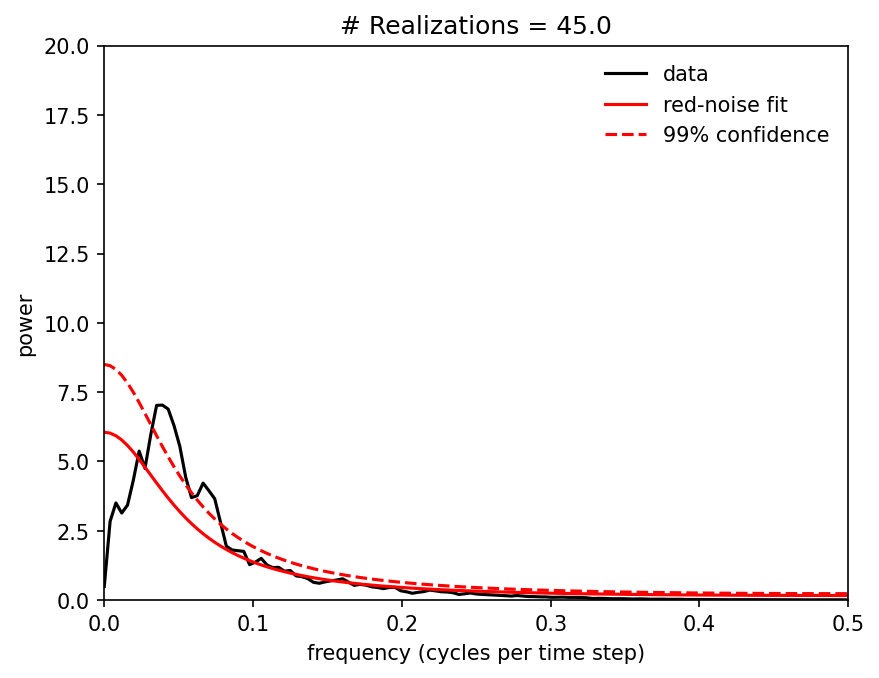

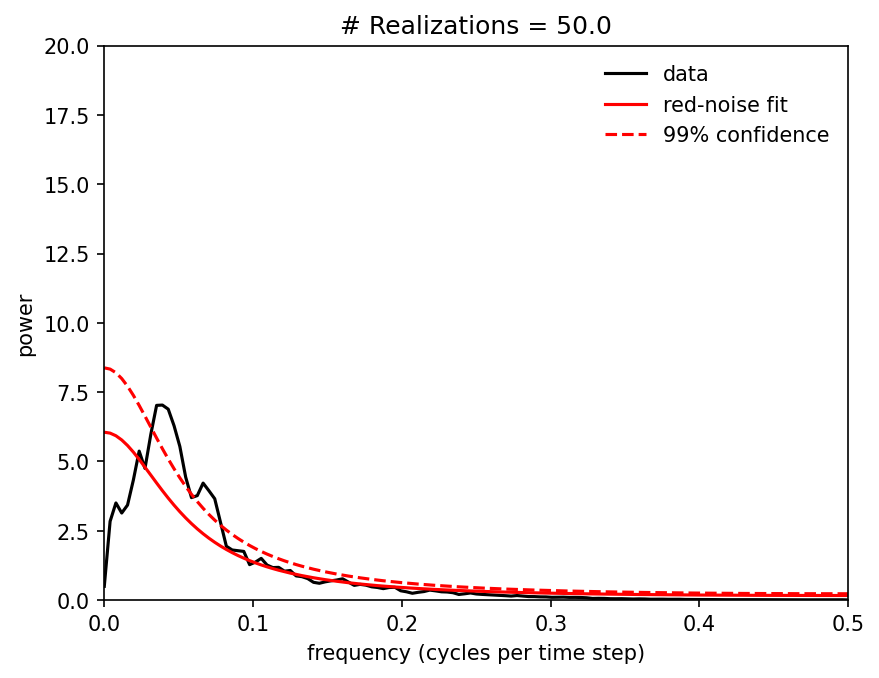

In [258]:
# factor = np.sqrt(1.-alpha*alpha)
# x = np.zeros(T,)

# loop realizations
for ir in np.arange(0,N,1):
    
    # # make a fake red noise time series
    # x = np.zeros(T,)
    # x[0] = x[-1]*alpha + factor*np.random.randn()

    # for j in np.arange(1,T,1):
    #     #add a cosine to our data to give it some additional power at a particular frequency of 50/256=0.2 cycles/time step
    #     x[j] = (x[j-1]*alpha 
    #             + factor*np.random.randn() 
    #             + 0.55*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*50./256.*j)
    #            )
    
    # # for illustrative purposes, add a mean for x (comment out)
    # x = x + 1.
    # 
    if(ir==0):
        plt.figure()
        plt.plot(x)
        plt.title('plot of chunk 1 of time series x(t)')
        plt.xlabel('time')
        plt.ylabel('value')
        plt.show()
    
    # calculate the power spectrum using a hanning window
    p = sig.welch(x,window='hann', nperseg=T, detrend='constant') #detrend='constant', None, 'linear'
    if(ir==0):
        psum = p[1]
    else:
        psum = psum + p[1]

    # calculate average    
    pave = psum/(ir+1.0)
    #normalize the spectrum
    pave = pave/np.mean(pave)
 
    
    # calculate significance
    dof = 2.*(ir+1.)
    fstat = stats.f.ppf(.99,dof,1000)
    spec99 = [fstat*m for m in rspec]
    
    if((ir+1.) % 5 == 0 or ir==0):       
        plt.figure()
        plt.xlabel('frequency (cycles per time step)')
        plt.ylabel('power')
        plt.title('# Realizations = ' + str(ir+1))
        plt.ylim(0,20.)
        plt.xlim(0,0.5)
        plt.plot(freq,pave,'-k', label = 'data')
        plt.plot(freq,rspec,'-', label = 'red-noise fit', color = 'red')
        plt.plot(freq,spec99,'--', label = '99% confidence', color = 'red')
        plt.legend(frameon = False)

plt.show()
